In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /Users/drey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/drey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#import annotated dataset
df = pd.read_csv('/Users/drey/Downloads/User Experience Spectrum Task - Annotated_data (1).csv')

In [3]:
df.head()

,Randomizer,reviewerID,asin,reviewerName,helpful,overall,reviewTime,summary,reviewText,User Experience Spectrum
0,1,A1NAA1R38JSNHV,B0002F7IIK,Josh Leger,"[0, 0]",5,1/4/2013,"works wonders, very durable",Will hold any guitar that I've seen. It holds ...,Thrilled
1,2,ADH0O8UVJOT10,B007Q27BH0,StormJH1,"[3, 3]",5,12/31/2012,Another instant classic from Joyo,"The US Dream is supposed ""clone"" of the Suhr R...",Insightful Feedback
2,4,A2E3Q52SJS00K2,B004N0MKN8,Wendell Burnett,"[0, 0]",5,1/3/2014,Great Idea,Those of us who have leaned their guitars agai...,Thrilled
3,6,A4BTCECGQAIUI,B0002M6CVC,Amazon Customer,"[0, 2]",4,5/30/2013,Good,"Good Strings, I buy this Strings from a few ye...",Thrilled
4,7,A7IBOCJ0K4V8C,B003VWJ2K8,J. Walker,"[0, 0]",5,5/6/2013,It works.,This tuner can be adjusted to be very easy to ...,Insightful Feedback


### EDA (Exploratory Data Analysis)

In [4]:
df.drop(['Randomizer'], axis=1, inplace=True)

In [5]:
df.tail(10)

,reviewerID,asin,reviewerName,helpful,overall,reviewTime,summary,reviewText,User Experience Spectrum
150,A22Z554ZQ8NFPC,B0002D0CKI,"AF ""Whigs""","[12, 12]",3,9/8/2011,Good & Bad,"First, I love these picks and used them exclus...",Mixed Emotions
151,A1B9Q3SNKI6T5V,B0002D0LKY,Dustin Kempton,"[0, 0]",1,5/2/2014,I really do hate it.,"It just randomly pops off my bass, it's so sli...",Opportunity Areas
152,A3NAA6BH9LWIH4,B001UJEKZ6,Paul Kacprzak,"[0, 2]",1,5/15/2013,I hate it.,The coversion cable didnt work. t is axlr to U...,Opportunity Areas
153,A1EQYR35KLTECN,B0002E1H9W,animulvr,"[0, 1]",3,1/6/2013,Hate the pushdown bottle heads!,I like Dunlop products but... The push down ap...,Opportunity Areas
154,A1QRF5KISDOKPA,B000SAC5PA,santos,"[6, 8]",1,12/23/2011,hate it,ok when i saw the bag i was impressed nice loo...,Opportunity Areas
155,A1VW19Y79DC0GF,B00186L9X2,"Andrew M. Ward ""My Stolen Life""","[13, 16]",3,8/31/2011,It's a Love / Hate Relationship...,It cannot be denied that the BOSS DD-7 is a ve...,Mixed Emotions
156,A15BHBF0L0HV1F,B0002D0E8S,"Quaestor ""Raoul Duke""","[0, 0]",3,11/30/2013,Nothing Special,Nothing special. Just like every other strap o...,Mixed Emotions
157,A3DDZ2SENG07MS,B003LTJ404,dashreeve,"[0, 0]",4,1/6/2012,Good stand - not the best for gigging / travel,"The stand seems sturdy, the base is like a tri...",Insightful Feedback
158,A1EFXXRDV40C4E,B003SZDFM4,Charles Casterline,"[2, 2]",3,12/16/2012,Nothing to brag about,I use to have a guitar that sounded horrible w...,Opportunity Areas
159,A1FCX548TD6DLP,B003QTM9O2,Cooper the Beagle,"[0, 0]",1,1/9/2014,"Poorly Made, Flimsy. Buy Another Product","At the time I bought, was $16. Mine arrived br...",Opportunity Areas


In [6]:
missing_values = df.isna().sum() * 100 / df.shape[0]
missing_values.sort_values(ascending=False)
missing_values
# missing_values[missing_values > 0].sort_values(ascending=True)

reviewerID                  0.0
asin                        0.0
reviewerName                0.0
helpful                     0.0
overall                     0.0
reviewTime                  0.0
summary                     0.0
reviewText                  0.0
User Experience Spectrum    0.0
dtype: float64

# Feature Engineering

In [7]:
# Define numerical labels for User Experience Spectrum
spectrum_labels = {'Thrilled': 0, 'Insightful Feedback': 1, 'Mixed Emotions': 2, 'Opportunity Areas': 3}

# Apply labels to the 'user_experience_spectrum' column
df['user_experience_labels'] = df['User Experience Spectrum'].map(spectrum_labels)


In [8]:
# Initializing necessary libraries and tools
en_stopwords = set(stopwords.words('english'))  # Set of English stopwords
tokenizer = RegexpTokenizer(r'\w+')  # Regular expression tokenizer to split words

# Tokenization
df['tokenized_text'] = df['reviewText'].apply(tokenizer.tokenize)
# Creating a new column 'tokenized_text' containing lists of tokenized words for each review in the 'reviewText' column

# Stopword removal
stop_words = set(stopwords.words('english'))  # Set of English stopwords
df['filtered_tokens'] = df['tokenized_text'].apply(lambda tokens: [word for word in tokens if word.lower() not in en_stopwords])
# Creating a new column 'filtered_tokens' containing lists of words after removing stopwords from 'tokenized_text'

# Stemming
ps = PorterStemmer()  # Porter Stemmer for stemming words
df['stemmed_tokens'] = df['filtered_tokens'].apply(lambda tokens: [ps.stem(word) for word in tokens])
# Creating a new column 'stemmed_tokens' containing lists of stemmed words from 'filtered_tokens'

# Combine preprocessed tokens
df['processed_text'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))
# Creating a new column 'processed_text' containing preprocessed text by joining the stemmed tokens into a single string


In [9]:
# Tokenization for 'summary'
df['tokenized_summary'] = df['summary'].apply(tokenizer.tokenize)
# Creating a new column 'tokenized_summary' containing lists of tokenized words for each summary in the 'summary' column

# Stopword removal for 'summary'
df['filtered_summary_tokens'] = df['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in en_stopwords])
# Creating a new column 'filtered_summary_tokens' containing lists of words after removing stopwords from 'tokenized_summary'

# Stemming for 'summary'
df['stemmed_summary_tokens'] = df['filtered_summary_tokens'].apply(lambda tokens: [ps.stem(word) for word in tokens])
# Creating a new column 'stemmed_summary_tokens' containing lists of stemmed words from 'filtered_summary_tokens'

In [10]:
# Combine preprocessed tokens for 'summary'
df['processed_summary'] = df['stemmed_summary_tokens'].apply(lambda tokens: ' '.join(tokens))
# Creating a new column 'processed_summary' containing preprocessed text by joining the stemmed tokens into a single string for summary

# Concatenate 'summary' and 'reviewText' for a holistic input
df['combined_text'] = df['processed_text'] + ' ' + df['processed_summary']
# Creating a new column 'combined_text' by concatenating the preprocessed text from 'processed_text' and 'processed_summary'


# Preprocess Data For Training

In [11]:
# Use StratifiedShuffleSplit for splitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=30)
# Initializing StratifiedShuffleSplit with 1 split, 20% test size, and a random seed for reproducibility

# Convert indices to lists
train_indices, dev_indices = next(sss.split(df['combined_text'], df['user_experience_labels']))
# Applying the split on 'combined_text' and 'user_experience_labels' columns and obtaining the training and development set indices

# Split the entire dataset into training and testing
X_train, X_test = df['combined_text'].iloc[train_indices].tolist(), df['combined_text'].iloc[dev_indices].tolist()
# Extracting the training and testing data for the 'combined_text' column and converting them to lists

y_train, y_test = df['user_experience_labels'].iloc[train_indices].tolist(), df['user_experience_labels'].iloc[dev_indices].tolist()
# Extracting the corresponding labels for training and testing and converting them to lists


In [12]:
# Further split train_dev into training and development sets
train_indices, dev_indices = next(sss.split(X_train, y_train))
# Using the previously defined StratifiedShuffleSplit to split the training data (X_train) and its corresponding labels (y_train)
# Obtaining indices for training and development sets

# Extracting data for training and development sets
X_train, X_dev = [X_train[i] for i in train_indices], [X_train[i] for i in dev_indices]
# Creating lists of texts for training and development sets based on the indices obtained

y_train, y_dev = [y_train[i] for i in train_indices], [y_train[i] for i in dev_indices]
# Creating lists of labels for training and development sets based on the indices obtained


In [13]:
#Exclude Nan values from training
df.dropna(subset=['user_experience_labels'], inplace=True)

In [14]:
# Bag of Words (BoW) vectorization
bow_vectorizer = CountVectorizer()
# Creating a CountVectorizer object for Bag of Words (BoW) vectorization

X_train_bow = bow_vectorizer.fit_transform(X_train)
# Transforming the training text data (X_train) into BoW vectors
# The fit_transform method both fits the vectorizer to the training data and transforms it

X_test_bow = bow_vectorizer.transform(X_test)
# Transforming the testing text data (X_test) into BoW vectors using the same vectorizer
# It's important to use the same vectorizer instance for consistency in feature representation


In [15]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

The code below initializes and trains multiple machine learning models, including Support Vector Machine (SVM), Logistic Regression, Naive Bayes, Random Forest, and Gradient Boosting. It then evaluates each model's performance on the development set, printing accuracy and a detailed classification report.

In [16]:
# Initialize and train different models
models = {
    'SVM': SVC(kernel='linear', C=1),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}
# Create a dictionary of model names as keys and corresponding model instances as values
# Each model is initialized with its specified parameters

# Evaluate multiple models
for name, model in models.items():
    # Iterate through each model in the dictionary
    
    # Train the model on the training set
    model.fit(X_train_tfidf, y_train)
    # Fit the model using the training data (X_train_tfidf) and corresponding labels (y_train)
    
    # Evaluate on the development set
    y_dev_pred = model.predict(X_dev_tfidf)
    # Predict the labels for the development set using the trained model
    
    dev_accuracy = accuracy_score(y_dev, y_dev_pred)
    # Calculate the accuracy of the model on the development set
    
    dev_classification_report = classification_report(y_dev, y_dev_pred)
    # Generate a classification report including precision, recall, and F1-score
    
    # Print the evaluation results for each model
    print(f'\n{name} Development Accuracy: {dev_accuracy:.4f}')
    print('Development Classification Report:\n', dev_classification_report)



SVM Development Accuracy: 0.6154
Development Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76        16
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.62        26
   macro avg       0.15      0.25      0.19        26
weighted avg       0.38      0.62      0.47        26


Logistic Regression Development Accuracy: 0.6154
Development Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.76        16
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.62        26
   macro avg       0.15      0.25      0.19        26
weighted avg       0.38      

## Improving Model Accuracy

In [17]:
# Install the XGBoost library if not already installed
!pip install xgboost

# Import necessary libraries
import numpy as np
from gensim.models import Word2Vec
from xgboost import XGBClassifier

# Assuming X_train and X_test are lists of texts
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# Train a Word2Vec model on the processed text data
word2vec_model = Word2Vec(sentences=df['processed_text'], vector_size=100)

# Extract vocabulary and vector size from the Word2Vec model
vocab = word2vec_model.wv.key_to_index
vector_size = 100

def get_word2vec_vectors(text):
    # Function to obtain the word vectors for each word in a given text
    vec = np.zeros(vector_size)
    count = 0 
    for word in text.split():
        if word in vocab:
            index = vocab[word]
            vec += word2vec_model.wv[index]  
            count += 1
    if count > 0:  
        vec /= count
        return vec

# Convert text data to matrices using Word2Vec vectors
num_train = X_train_array.shape[0] 
num_test = X_test_array.shape[0]

X_train_w2v_matrix = np.zeros((num_train, vector_size))
for i, text in enumerate(X_train_array):
    X_train_w2v_matrix[i, :] = get_word2vec_vectors(text)
    
X_test_w2v_matrix = np.zeros((num_test, vector_size))
for i, text in enumerate(X_test_array):
    X_test_w2v_matrix[i, :] = get_word2vec_vectors(text)

# Train an XGBoost classifier using the Word2Vec matrices
# xgb = XGBClassifier()
# xgb.fit(X_train_w2v_matrix, y_train)
# print(xgb.score(X_test_w2v_matrix, y_test))


## Hyperparameter Tuning

In [18]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define a dictionary of hyperparameter values to search over
param_grid = {
    'max_depth': np.arange(3, 11),  
    'learning_rate': np.linspace(.01, 1, 20), 
    'gamma': np.linspace(.01, 10, 20), 
    'min_child_weight': np.linspace(.01, 10, 20),  
    'subsample': np.linspace(.1, 1, 20),  
    'colsample_bytree': np.linspace(.1, 1, 20),  
    'reg_alpha': np.linspace(.01, 1, 20), 
    'reg_lambda': np.linspace(.01, 1, 20),  
    'n_estimators': np.arange(10, 100, 5),  
    'max_delta_step': np.random.uniform(0.5, 2, 5),  
    'colsample_bylevel': np.random.uniform(0.5, 1, 5), 
    'scale_pos_weight': np.random.uniform(0.5, 2, 5) 
}

# Initialize an XGBoost classifier
xgb = XGBClassifier()

# The new search strategy
# gs_cv = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=5)  # Grid Search
rs_cv = RandomizedSearchCV(xgb, param_grid, n_iter=100, scoring="accuracy", n_jobs=-1, cv=5, random_state=42)  # Randomized Search

# Perform hyperparameter tuning on the Word2Vec matrix training data
rs_cv.fit(X_train_w2v_matrix, y_train)  

# Print the best hyperparameters found during the search
print("Best params:", rs_cv.best_params_)

# Obtain the best model with the optimal hyperparameters
best_model = rs_cv.best_estimator_

# Predict labels for the test set using the best model
y_pred = best_model.predict(X_test_w2v_matrix)

# Evaluate the accuracy of the model on the test set
test_accuracy = best_model.score(X_test_w2v_matrix, y_test)
print("Test set accuracy:", test_accuracy)


/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

Best params: {'subsample': 0.7631578947368421, 'scale_pos_weight': 1.657706190311406, 'reg_lambda': 0.4789473684210527, 'reg_alpha': 0.01, 'n_estimators': 15, 'min_child_weight': 7.371052631578948, 'max_depth': 10, 'max_delta_step': 0.7912670882343076, 'learning_rate': 0.6873684210526316, 'gamma': 0.01, 'colsample_bytree': 0.8578947368421053, 'colsample_bylevel': 0.8729461494958455}
Test set accuracy: 0.625


/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/drey/anac

In [19]:
# Obtain the best model with the optimal hyperparameters
best_model = rs_cv.best_estimator_

# Predict labels for the test set using the best model
y_pred = best_model.predict(X_test_w2v_matrix)

# Evaluate the accuracy of the model on the test set
test_accuracy = best_model.score(X_test_w2v_matrix, y_test)

# Print the test set accuracy
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.625


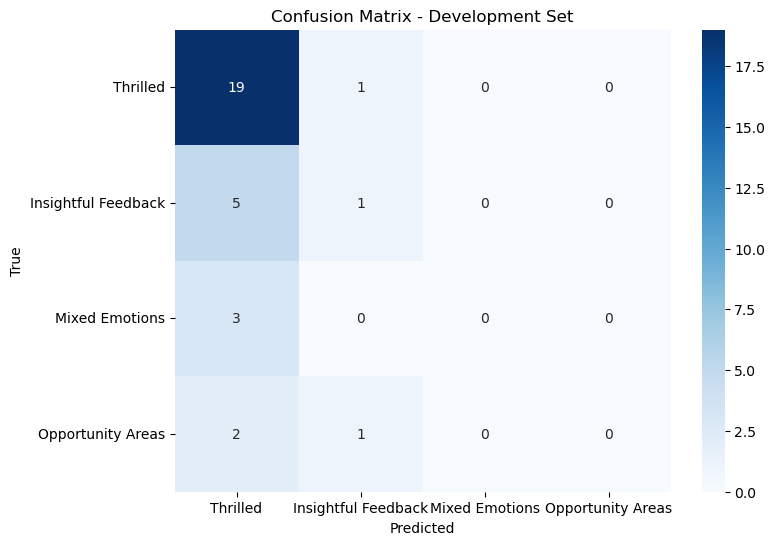

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have trained your model and made predictions on the development set

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=spectrum_labels.keys(), yticklabels=spectrum_labels.keys())
plt.title('Confusion Matrix - Development Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Exporting Model Output for UI implementation

In [21]:
!pip install joblib

In [22]:
import joblib

joblib.dump(en_stopwords,'stopwords.pkl') 
joblib.dump(rs_cv,'model.pkl', compress=('zlib', 3))
joblib.dump(tfidf_vectorizer,'vectorizer.pkl')

['vectorizer.pkl']